In [1]:
import os, math, warnings, itertools, random
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, roc_curve, confusion_matrix, average_precision_score
from sklearn.metrics import precision_score, recall_score, brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
import lightgbm as lgb

import matplotlib.pyplot as plt
import xgboost as xgb

warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)


In [2]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
DATA = '/content/Assignment_Data.xlsx'
TARGET_COL = 'readmitted_30_days'
RANDOM_STATE = 42

In [3]:
df = pd.read_excel(DATA)

# 1. Data Sanity

In [4]:
print('Shape:', df.shape)

Shape: (200, 9)


In [5]:
df.columns

Index(['patient_id', 'age', 'gender', 'diagnosis_code',
       'num_previous_admissions', 'medication_type', 'length_of_stay',
       'readmitted_30_days', 'discharge_note'],
      dtype='object')

In [6]:
df.head()

,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note
0,1,71,Male,D002,3,Type C,2,0,Good recovery trajectory. Follow-up scan sched...
1,2,34,Female,D002,1,Type B,3,1,Stable post-surgery. Advised to avoid physical...
2,3,80,Male,D002,2,Type C,5,1,Symptoms controlled. Monitoring for relapse ad...
3,4,40,Female,D002,2,Type C,11,0,Stable post-surgery. Advised to avoid physical...
4,5,43,Female,D001,1,Type C,8,1,Stable post-surgery. Advised to avoid physical...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               200 non-null    int64 
 1   age                      200 non-null    int64 
 2   gender                   200 non-null    object
 3   diagnosis_code           200 non-null    object
 4   num_previous_admissions  200 non-null    int64 
 5   medication_type          200 non-null    object
 6   length_of_stay           200 non-null    int64 
 7   readmitted_30_days       200 non-null    int64 
 8   discharge_note           200 non-null    object
dtypes: int64(5), object(4)
memory usage: 14.2+ KB


In [8]:
df['readmitted_30_days'].value_counts(), df['readmitted_30_days'].value_counts(normalize=True)

(readmitted_30_days
 0    135
 1     65
 Name: count, dtype: int64,
 readmitted_30_days
 0    0.675
 1    0.325
 Name: proportion, dtype: float64)

In [9]:
df.describe()

,patient_id,age,num_previous_admissions,length_of_stay,readmitted_30_days
count,200.000000,200.000000,200.000000,200.000000,200.00000
mean,100.500000,53.720000,1.600000,7.865000,0.32500
std,57.879185,21.294574,1.310951,4.134276,0.46955
min,1.000000,20.000000,0.000000,1.000000,0.00000
25%,50.750000,34.000000,1.000000,4.000000,0.00000
50%,100.500000,54.000000,1.000000,8.000000,0.00000
75%,150.250000,73.000000,2.000000,11.000000,1.00000
max,200.000000,89.000000,6.000000,14.000000,1.00000


In [10]:
df.isna().sum() / len(df)

,0
patient_id,0.0
age,0.0
gender,0.0
diagnosis_code,0.0
num_previous_admissions,0.0
medication_type,0.0
length_of_stay,0.0
readmitted_30_days,0.0
discharge_note,0.0


In [11]:
df.duplicated().sum()

np.int64(0)

In [12]:
df.nunique()

,0
patient_id,200
age,67
gender,2
diagnosis_code,4
num_previous_admissions,7
medication_type,3
length_of_stay,14
readmitted_30_days,2
discharge_note,10


### Observations

- Dataset shape: 200 rows and 9 columns
- No missing values or duplicates found
- patient_id is unique and acts as an identifier
- Target variable "readmitted_30_days" is binary (0/1) with slight imbalance (67.5% vs 32.5%)
- Categorical columns are low-cardinality and clean
- Text column "discharge_note" present, no missing values, 10 unique templates

- Overall: Data is clean and consistent


## 1.3 Categorical sanity check

In [13]:
for col in ['gender', 'diagnosis_code', 'medication_type']:
    print(f"\n{col}:")
    print(df[col].unique())


gender:
['Male' 'Female']

diagnosis_code:
['D002' 'D001' 'D004' 'D003']

medication_type:
['Type C' 'Type B' 'Type A']


In [14]:
df['discharge_note'].sample(5, random_state=1).values

array(['Good recovery trajectory. Follow-up scan scheduled next month.',
       'No further signs of infection. Resume normal diet and activity.',
       'Mild reaction to medication. Switched to alternative treatment.',
       'Patient discharged with minor discomfort. Advised rest and hydration.',
       'Mild reaction to medication. Switched to alternative treatment.'],
      dtype=object)

# 2. Train test split

- Before I proceed for any kind of pattern finding/EDA, I need to split the data into train and test. This is done to unsure that test is unseen and serves as true evaluation of the model.

In [15]:
from sklearn.model_selection import train_test_split

# 15% test
train_val_df, test_df = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    stratify=df['readmitted_30_days']
)

# 15% val from the remaining 85%
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.176,  # 0.176 × 0.85 ≈ 0.15 of total
    random_state=42,
    stratify=train_val_df['readmitted_30_days']
)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")



Train: 140 | Val: 30 | Test: 30


In [16]:
for name, d in zip(['Train', 'Val', 'Test'], [train_df, val_df, test_df]):
    print(f"\n{name} class balance:")
    print(d['readmitted_30_days'].value_counts(normalize=True))


Train class balance:
readmitted_30_days
0    0.678571
1    0.321429
Name: proportion, dtype: float64

Val class balance:
readmitted_30_days
0    0.666667
1    0.333333
Name: proportion, dtype: float64

Test class balance:
readmitted_30_days
0    0.666667
1    0.333333
Name: proportion, dtype: float64


# 3. EDA

### 3.1 Outlier Analysis


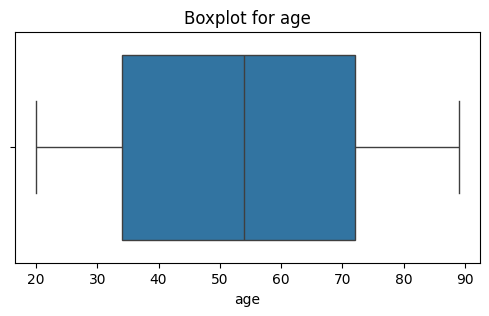

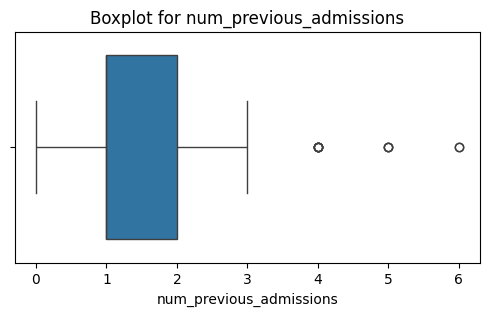

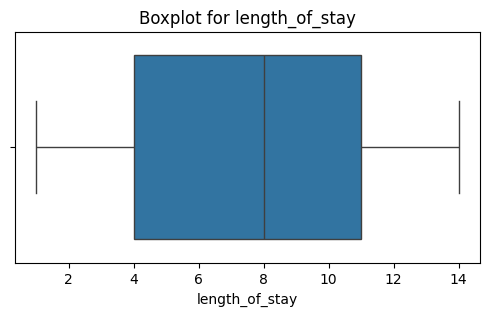

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ['age', 'num_previous_admissions', 'length_of_stay']

for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=train_df[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

In [18]:
from scipy import stats
import numpy as np

z_scores = np.abs(stats.zscore(train_df[num_cols]))
outliers = (z_scores > 3).sum()
pd.DataFrame(outliers, index=num_cols, columns=['n_outliers'])

,n_outliers
age,2
num_previous_admissions,2
length_of_stay,2


### Observations

- Mild outliers in num_previous_admissions (4 - 6 admissions), but these represent valid clinical variability.
- Z score analysis flagged two potential outliers in each column (|z| > 3), consistent with the visual findings.
- No extreme or erroneous outliers were found, data consistent and realistic.
- Decision: retain all records.

## 3.1 Correlation

In [19]:
corr_pearson = train_df[['age', 'num_previous_admissions', 'length_of_stay', 'readmitted_30_days']].corr(method='pearson')
corr_spearman = train_df[['age', 'num_previous_admissions', 'length_of_stay', 'readmitted_30_days']].corr(method='spearman')

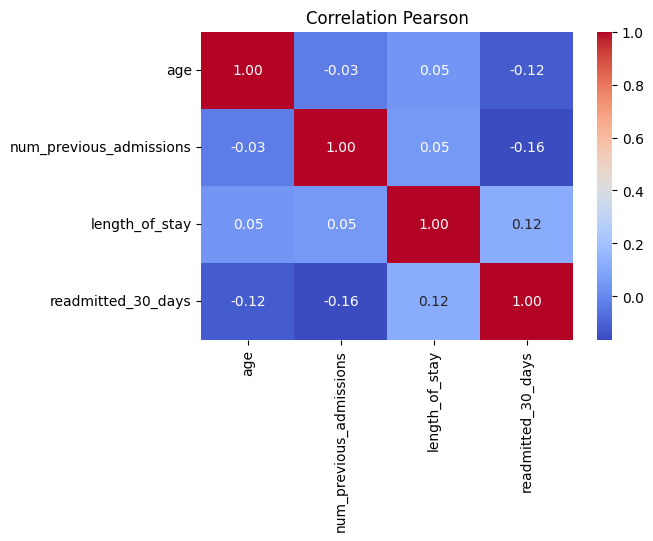

In [20]:
plt.figure(figsize=(6,4))
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Pearson')
plt.show()

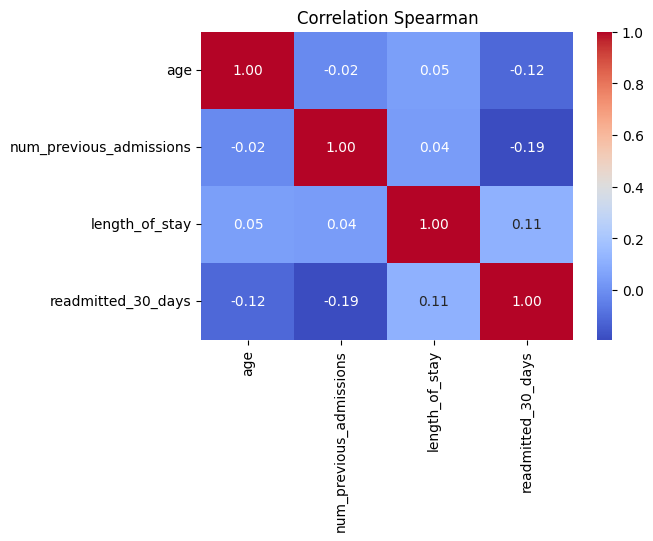

In [21]:
plt.figure(figsize=(6,4))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Spearman')
plt.show()

### Correlation Analysis (Pearson vs Spearman)

- Both Pearson and Spearman correlation matrices were generated to capture linear and monotonic relationships.
- The results are nearly identical across both methods indicating that:
  - Numeric features behave linearly and are not strongly skewed or ordinal.
  - There are no hidden monotonic relationships that Pearson might miss.
- All correlation values are weak (< 0.2 in absolute terms) suggesting minimal linear association between predictors and the target (readmitted_30_days).
- No multicollinearity issues among numeric features.
- Slight trends observed:
  - "length_of_stay" has a mild positive relationship with readmission.
  - "num_previous_admissions" shows a weak negative trend.
- **Conclusion:** Pearson correlation is appropriate for this dataset and numeric features show limited direct predictive signal.


### EDA Helper Function

In [22]:
# helper functions

def hist_plot(data, col, kde=True, bins=15, figsize=(5,3)):
    plt.figure(figsize=figsize)
    sns.histplot(data[col], kde=kde, bins=bins)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

def bar_count_plot(data, col, figsize=(5,3)):

    plt.figure(figsize=figsize)
    order = data[col].value_counts().index
    ax = sns.countplot(x=data[col], order=order, palette='pastel', edgecolor='black')

    total = len(data)

    for p in ax.patches:
        count = int(p.get_height())
        percentage = 100 * count / total
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() / 2

        ax.text(x, y, f'{count}\n({percentage:.1f}%)',
                ha='center', va='center', color='black', fontsize=9)

    # Titles and labels
    plt.title(f'{col} Distribution', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

def box_plot(data, col, target, figsize=(5,3)):

    plt.figure(figsize=figsize)
    sns.boxplot(x=target, y=col, data=data, palette='pastel', showfliers=True)
    plt.title(f'{col} by {target}', fontsize=12, weight='bold')
    plt.xlabel(target)
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

def target_rate_bar(data, col, target='readmitted_30_days', figsize=(5,3)):

    plt.figure(figsize=figsize)

    rate = data.groupby(col)[target].mean().sort_values(ascending=False)

    ax = sns.barplot(x=rate.index, y=rate.values * 100, palette='pastel', edgecolor='black')

    # Add percentage labels inside bars
    for i, p in enumerate(ax.patches):
        value = rate.values[i] * 100
        ax.text(p.get_x() + p.get_width()/2,
                p.get_height()/2,
                f'{value:.1f}%',
                ha='center', va='center', color='black', fontsize=9)

    plt.title(f'Readmission Rate by {col}', fontsize=12)
    plt.ylabel('Readmission Rate (%)')
    plt.xlabel(col)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


## 3.2 Univariate Analysis

### 3.2.1 Numerical Variable

In [23]:
num_cols = ['age', 'num_previous_admissions', 'length_of_stay']
train_df[num_cols].describe()

,age,num_previous_admissions,length_of_stay
count,140.000000,140.000000,140.000000
mean,53.657143,1.578571,7.685714
std,21.321037,1.325282,4.115396
min,20.000000,0.000000,1.000000
25%,34.000000,1.000000,4.000000
50%,54.000000,1.000000,8.000000
75%,72.000000,2.000000,11.000000
max,89.000000,6.000000,14.000000


In [24]:
# for col in num_cols:
#     plt.figure(figsize=(5,3))
#     sns.histplot(df[col], kde=True, bins=15)
#     plt.title(f'Distribution of {col}')
#     plt.show()

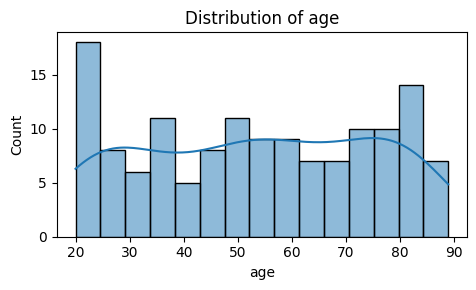

In [25]:
hist_plot(train_df, 'age', kde=True, bins=15)

- Distribution looks fairly uniform between 20 and 90 years.

- No strong skewness, every age group is well represented.

- This suggests that age diversity in the dataset is good

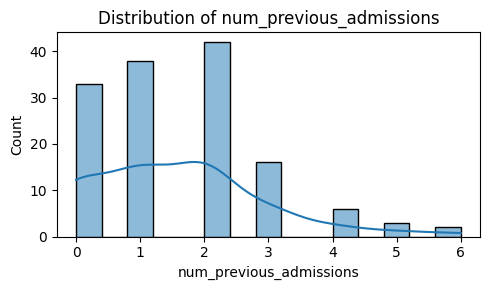

In [26]:
hist_plot(train_df, 'num_previous_admissions', kde=True, bins=15)

- Distribution is right skewed, most patients have 0 – 2 previous admissions, very few have >3.

- Long tail indicates a small subset of patients are frequent visitors.

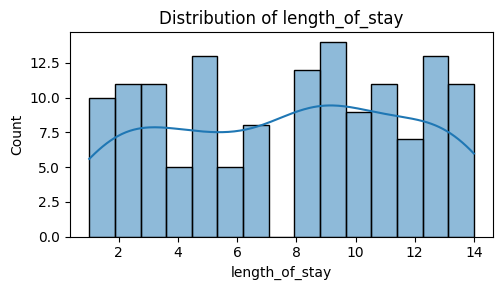

In [27]:
hist_plot(train_df, 'length_of_stay', kde=True, bins=15)

- Fairly uniform distribution between 1- 14 days, no major skew.

- Suggests a good mix of short and long hospital stays.

### 3.2.2 Categorical Variable

In [28]:
cat_cols = ['gender', 'diagnosis_code', 'medication_type']

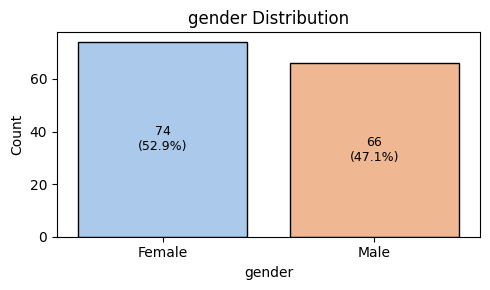

In [29]:
bar_count_plot(train_df, 'gender')

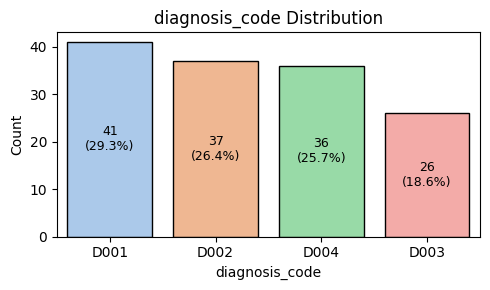

In [30]:
bar_count_plot(train_df, 'diagnosis_code')

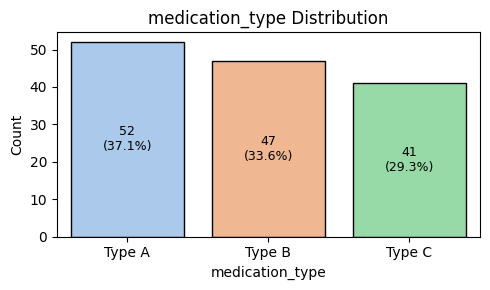

In [31]:
bar_count_plot(train_df, 'medication_type')

## 3.3 Bivariate analysis with Target

### 3.3.1 Numerical vs Target

In [32]:
num_cols = ['age', 'num_previous_admissions', 'length_of_stay']

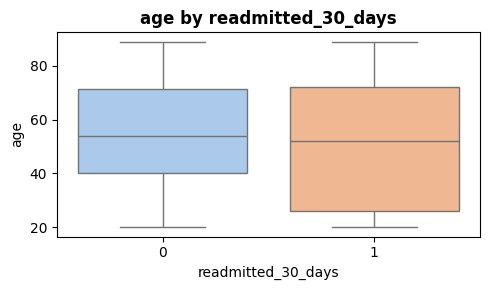

In [33]:
box_plot(train_df, 'age', target='readmitted_30_days')

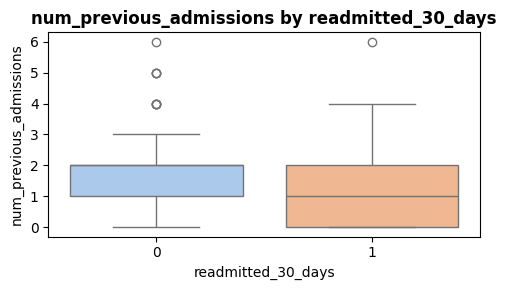

In [34]:
box_plot(train_df, 'num_previous_admissions', target='readmitted_30_days')

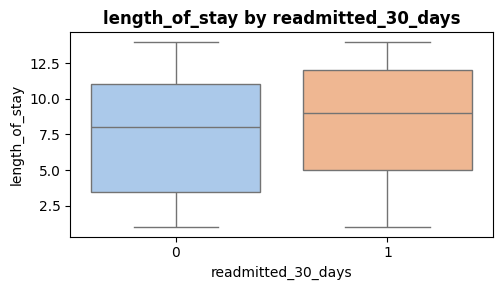

In [35]:
box_plot(train_df, 'length_of_stay', target='readmitted_30_days')

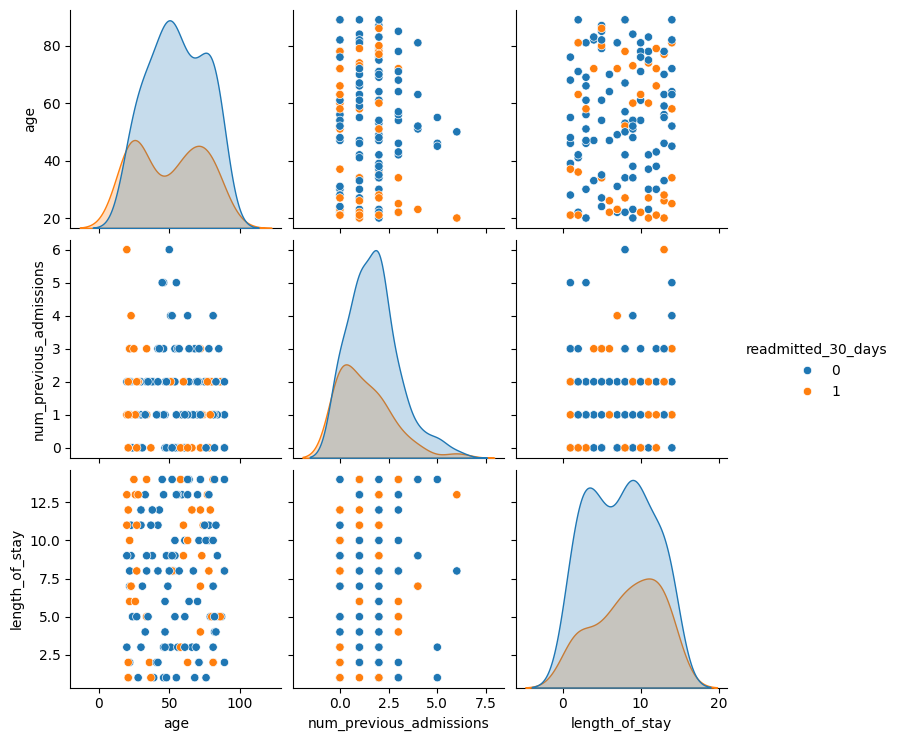

In [36]:
sns.pairplot(train_df, vars=num_cols, hue='readmitted_30_days')

### 3.3.2 Categorical vs Target

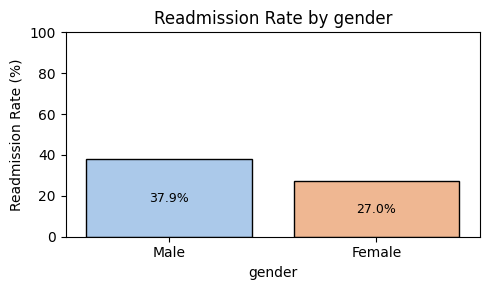

In [37]:
target_rate_bar(train_df, 'gender')

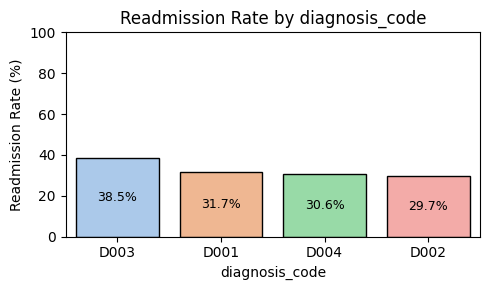

In [38]:
target_rate_bar(train_df, 'diagnosis_code')

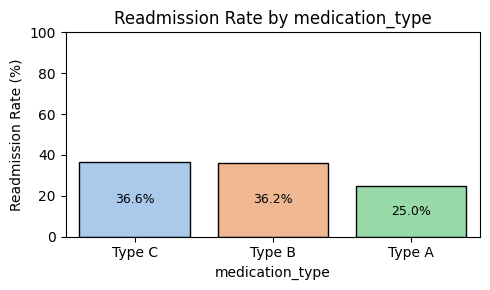

In [39]:
target_rate_bar(train_df, 'medication_type')

## 3.4 Multivariate Analysis with Target

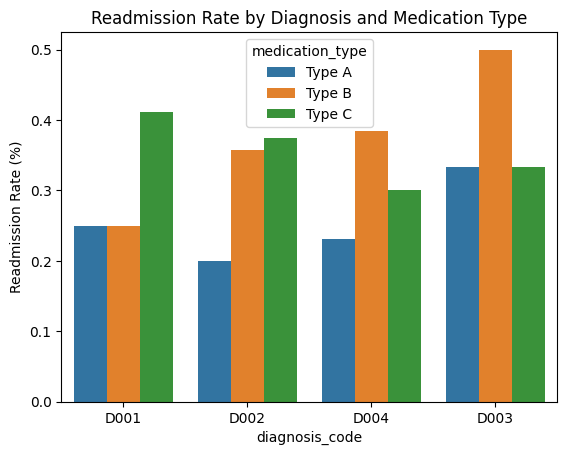

In [40]:
sns.barplot(
    data=train_df,
    x="diagnosis_code",
    y="readmitted_30_days",
    hue="medication_type",
    estimator=np.mean,
    ci=None
)
plt.title("Readmission Rate by Diagnosis and Medication Type")
plt.ylabel("Readmission Rate (%)")
plt.show()

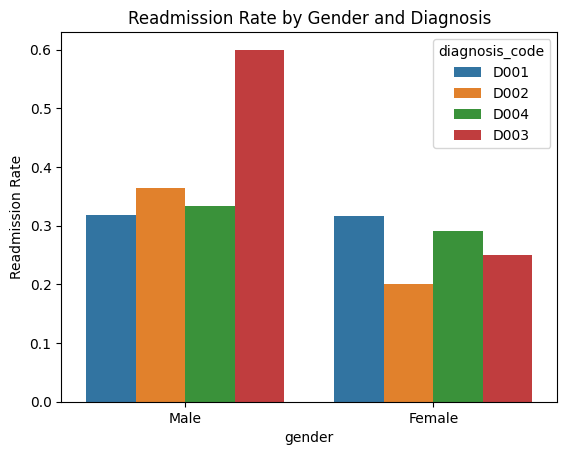

In [41]:
sns.barplot(
    data=train_df,
    x="gender",
    y="readmitted_30_days",
    hue="diagnosis_code",
    estimator=np.mean,
    ci=None
)
plt.title("Readmission Rate by Gender and Diagnosis")
plt.ylabel("Readmission Rate")
plt.show()

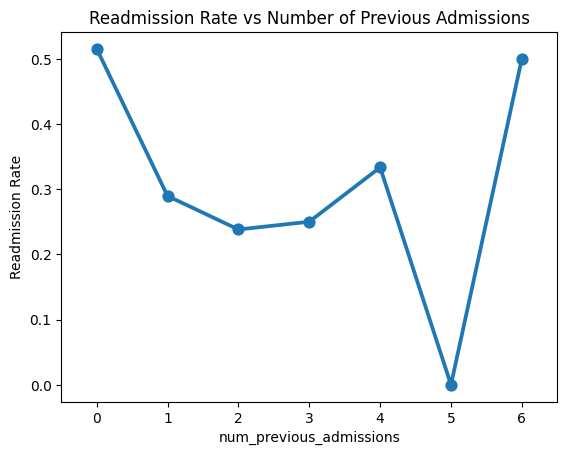

In [42]:
sns.pointplot(
    data=train_df,
    x="num_previous_admissions",
    y="readmitted_30_days",
    estimator=np.mean,
    ci=None
)
plt.title("Readmission Rate vs Number of Previous Admissions")
plt.ylabel("Readmission Rate")
plt.show()

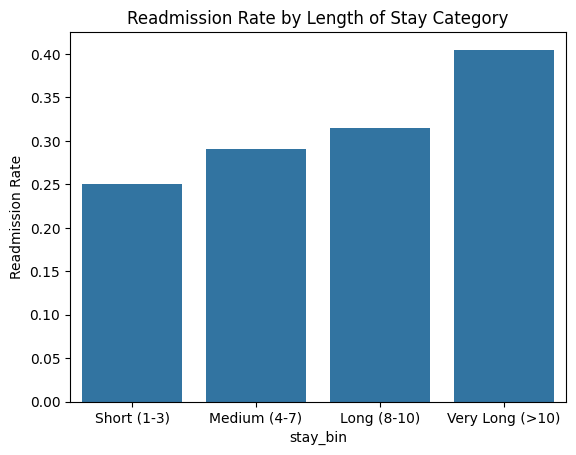

In [43]:
train_df["stay_bin"] = pd.cut(train_df["length_of_stay"],
                        bins=[0,3,7,10,15],
                        labels=["Short (1-3)", "Medium (4-7)", "Long (8-10)", "Very Long (>10)"])

sns.barplot(data=train_df, x="stay_bin", y="readmitted_30_days", ci=None)
plt.title("Readmission Rate by Length of Stay Category")
plt.ylabel("Readmission Rate")
plt.show()

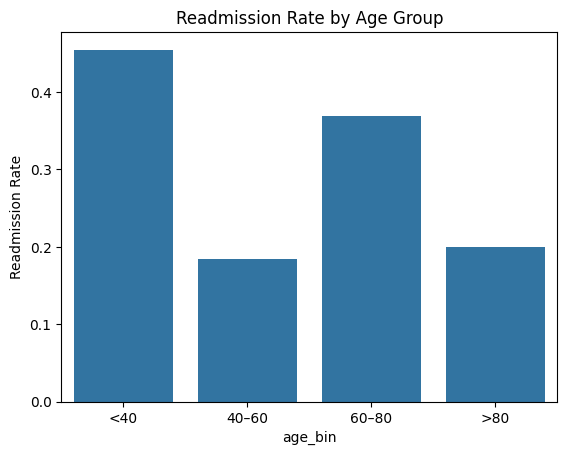

In [44]:
train_df["age_bin"] = pd.cut(train_df["age"],
                       bins=[0,40,60,80,100],
                       labels=["<40","40–60","60–80",">80"])

sns.barplot(data=train_df, x="age_bin", y="readmitted_30_days", ci=None)
plt.title("Readmission Rate by Age Group")
plt.ylabel("Readmission Rate")
plt.show()

# 4. Feature Engineering

## 4.1 Reusable Feature Function

In [45]:
import pandas as pd

def one_level_te(train_df, dev_df, test_df, group_col, target_col, new_col_name):

    # global mean from TRAIN
    gmean = train_df[target_col].mean()

    # build mapping on TRAIN
    mapper = (
        train_df.groupby(group_col, dropna=False)[target_col]
        .mean()
        .to_dict()
    )

    # apply to TRAIN/DEV
    train_feat = train_df[group_col].map(mapper)
    dev_feat   = dev_df[group_col].map(mapper)
    test_feat   = test_df[group_col].map(mapper)
    # unseen categories -> global mean
    train_df[new_col_name] = train_feat.fillna(gmean)
    dev_df[new_col_name]   = dev_feat.fillna(gmean)
    test_df[new_col_name]   = test_feat.fillna(gmean)

    return train_df, dev_df, test_df, mapper, gmean


In [46]:
def two_level_te(train_df, dev_df, test_df, cols, target_col, new_col_name):

    assert len(cols) == 2, "Provide exactly two columns."

    gmean = train_df[target_col].mean()

    mapping = (
        train_df.groupby(cols, dropna=False)[target_col]
        .mean()
        .reset_index()
        .rename(columns={target_col: new_col_name})
    )

    # merge (clean for multi-key)
    tr = train_df.merge(mapping, on=cols, how="left")
    dv = dev_df.merge(mapping, on=cols, how="left")
    ts = test_df.merge(mapping, on=cols, how="left")

    tr[new_col_name] = tr[new_col_name].fillna(gmean)
    dv[new_col_name] = dv[new_col_name].fillna(gmean)
    ts[new_col_name] = ts[new_col_name].fillna(gmean)

    return tr, dv, ts, mapping, gmean


In [47]:
train_df.nunique()

,0
patient_id,140
age,63
gender,2
diagnosis_code,4
num_previous_admissions,7
medication_type,3
length_of_stay,14
readmitted_30_days,2
discharge_note,10
stay_bin,4


In [48]:
train_df['num_previous_admissions'].value_counts()

,count
num_previous_admissions,
2,42
1,38
0,33
3,16
4,6
5,3
6,2


## 4.2 Making Feature

In [49]:
cat_cols = ["diagnosis_code", "medication_type", "num_previous_admissions"]

mappers = {}  # keep for reference / debugging
for c in cat_cols:
    new_feat = f"te_{c}"
    train_df, val_df, test_df, mapper, gmean = one_level_te(
        train_df=train_df,
        dev_df=val_df,
        test_df=test_df,
        group_col=c,
        target_col="readmitted_30_days",
        new_col_name=new_feat
    )
    mappers[c] = {"mapper": mapper, "global_mean": gmean}

In [50]:
from itertools import combinations

pairs = list(combinations(["diagnosis_code", "medication_type", "num_previous_admissions"], 2))
pair_maps = {}

for a, b in pairs:
    new_feat = f"te2_{a}__{b}"
    train_df, val_df, test_df, map_df, gmean = two_level_te(
        train_df=train_df,
        dev_df=val_df,
        test_df=test_df,
        cols=[a, b],
        target_col="readmitted_30_days",
        new_col_name=new_feat
    )
    pair_maps[(a, b)] = {"mapping_df": map_df, "global_mean": gmean}


In [51]:
train_df.head()

,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note,stay_bin,age_bin,te_diagnosis_code,te_medication_type,te_num_previous_admissions,te2_diagnosis_code__medication_type,te2_diagnosis_code__num_previous_admissions,te2_medication_type__num_previous_admissions
0,69,79,Male,D001,2,Type A,5,0,Patient discharged in stable condition. Recomm...,Medium (4-7),60–80,0.317073,0.250000,0.238095,0.250000,0.142857,0.277778
1,96,54,Male,D002,0,Type B,9,0,No further signs of infection. Resume normal d...,Long (8-10),40–60,0.297297,0.361702,0.515152,0.357143,0.416667,0.538462
2,117,51,Female,D004,2,Type B,3,0,Stable post-surgery. Advised to avoid physical...,Short (1-3),40–60,0.305556,0.361702,0.238095,0.384615,0.272727,0.214286
3,195,42,Male,D001,3,Type C,8,0,Patient showed improvement. Prescribed antibio...,Long (8-10),40–60,0.317073,0.365854,0.250000,0.411765,0.200000,0.250000
4,10,49,Male,D002,2,Type A,7,0,Blood pressure under control. Continue current...,Medium (4-7),40–60,0.297297,0.250000,0.238095,0.200000,0.111111,0.277778


In [52]:
val_df.head()

,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note,te_diagnosis_code,te_medication_type,te_num_previous_admissions,te2_diagnosis_code__medication_type,te2_diagnosis_code__num_previous_admissions,te2_medication_type__num_previous_admissions
0,44,63,Female,D004,1,Type C,14,0,Good recovery trajectory. Follow-up scan sched...,0.305556,0.365854,0.289474,0.300000,0.363636,0.285714
1,49,69,Male,D002,0,Type A,12,0,Mild reaction to medication. Switched to alter...,0.297297,0.250000,0.515152,0.200000,0.416667,0.428571
2,53,73,Female,D003,2,Type A,9,1,Blood pressure under control. Continue current...,0.384615,0.250000,0.238095,0.333333,0.500000,0.277778
3,143,43,Female,D004,2,Type A,8,0,Good recovery trajectory. Follow-up scan sched...,0.305556,0.250000,0.238095,0.230769,0.272727,0.277778
4,48,55,Female,D001,3,Type B,8,0,Discharge after recovery from pneumonia. No co...,0.317073,0.361702,0.250000,0.250000,0.200000,0.000000


In [53]:
test_df.head()

,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note,te_diagnosis_code,te_medication_type,te_num_previous_admissions,te2_diagnosis_code__medication_type,te2_diagnosis_code__num_previous_admissions,te2_medication_type__num_previous_admissions
0,150,31,Male,D003,2,Type C,2,0,Patient showed improvement. Prescribed antibio...,0.384615,0.365854,0.238095,0.333333,0.500000,0.200000
1,62,67,Male,D002,0,Type C,14,1,Mild reaction to medication. Switched to alter...,0.297297,0.365854,0.515152,0.375000,0.416667,0.538462
2,5,43,Female,D001,1,Type C,8,1,Stable post-surgery. Advised to avoid physical...,0.317073,0.365854,0.289474,0.411765,0.142857,0.285714
3,200,79,Male,D001,5,Type A,13,1,Patient showed improvement. Prescribed antibio...,0.317073,0.250000,0.000000,0.250000,0.321429,0.000000
4,139,81,Male,D004,1,Type C,3,0,Discharge after recovery from pneumonia. No co...,0.305556,0.365854,0.289474,0.300000,0.363636,0.285714


In [54]:
train_df.isna().sum()

,0
patient_id,0
age,0
gender,0
diagnosis_code,0
num_previous_admissions,0
medication_type,0
length_of_stay,0
readmitted_30_days,0
discharge_note,0
stay_bin,0


In [55]:
val_df.isna().sum()

,0
patient_id,0
age,0
gender,0
diagnosis_code,0
num_previous_admissions,0
medication_type,0
length_of_stay,0
readmitted_30_days,0
discharge_note,0
te_diagnosis_code,0


In [56]:
test_df.isna().sum()

,0
patient_id,0
age,0
gender,0
diagnosis_code,0
num_previous_admissions,0
medication_type,0
length_of_stay,0
readmitted_30_days,0
discharge_note,0
te_diagnosis_code,0


In [57]:
train_df.columns

Index(['patient_id', 'age', 'gender', 'diagnosis_code',
       'num_previous_admissions', 'medication_type', 'length_of_stay',
       'readmitted_30_days', 'discharge_note', 'stay_bin', 'age_bin',
       'te_diagnosis_code', 'te_medication_type', 'te_num_previous_admissions',
       'te2_diagnosis_code__medication_type',
       'te2_diagnosis_code__num_previous_admissions',
       'te2_medication_type__num_previous_admissions'],
      dtype='object')

## 4.3 Final Features Set

In [58]:
feature = ['te_diagnosis_code', 'te_medication_type', 'te_num_previous_admissions',
       'te2_diagnosis_code__medication_type',
       'te2_diagnosis_code__num_previous_admissions','age','length_of_stay']

len(feature)

7

In [203]:
corr_pearson = train_df[feature].corr(method='pearson')
corr_spearman = train_df[feature].corr(method='spearman')

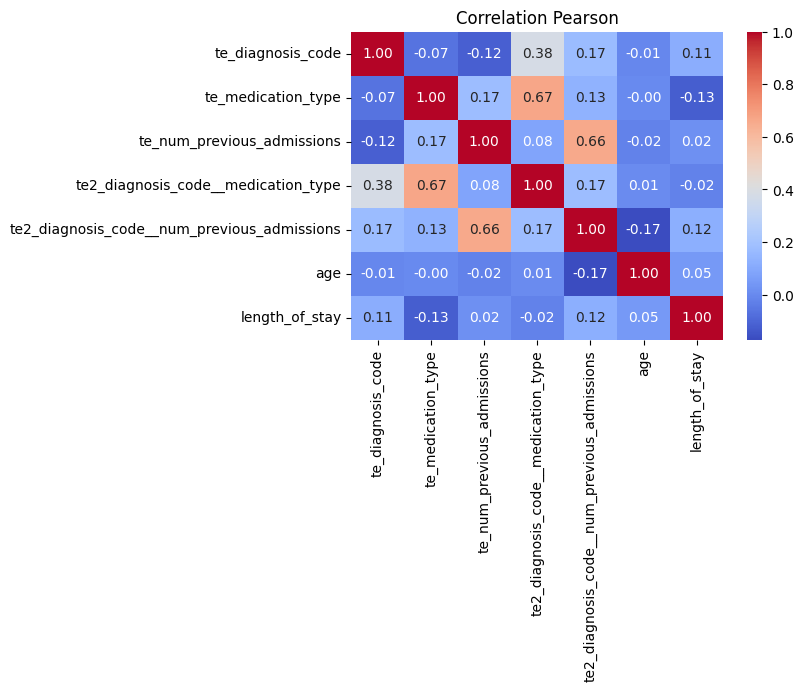

In [204]:
plt.figure(figsize=(6,4))
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Pearson')
plt.show()

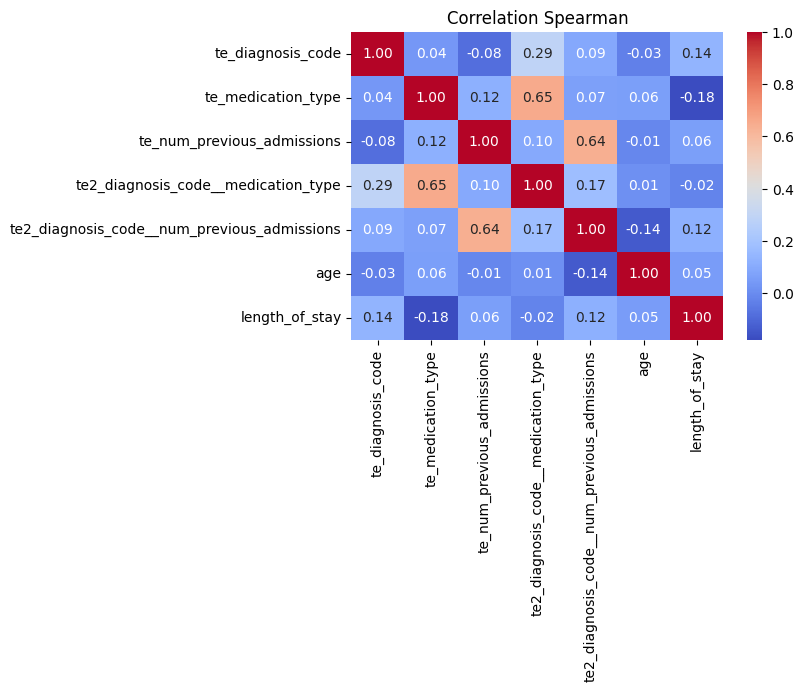

In [205]:
plt.figure(figsize=(6,4))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Spearman')
plt.show()

### Multicollinearity Assessment

- The correlation matrix shows moderate relationships between interaction-based target-encoded features and their base components
("te2_diagnosis_code__num_previous_admissions" vs "te_num_previous_admissions", r = 0.66).

- These correlations are expected given the hierarchical nature of the encodings and remain below typical risk thresholds (|r| < 0.8).  

- Tree based models (Decision Tree, Random Forest, LightGBM, XGBoost) are robust to correlated inputs,
and the regularized Logistic Regression model should stable coefficients.  

So, **multicollinearity should not be a concern** across any of the models

In [59]:
train_df.shape, val_df.shape, test_df.shape

((140, 17), (30, 15), (30, 15))

# 5. Modeling

### Prioritizing Recall

Hospital readmission prediction is a high impact problem where the **cost of missing an at-risk patient (false negative)** is higher than the cost of an unnecessary alert (false positive).

- A false negative means a patient is discharged as "low risk" but ends up being readmitted, a poor outcome for both patient health and hospital performance metrics.  
- A false positive means allocating limited resources (phone follow-ups or care-coordination checks) to a patient who ultimately remains stable.

Therefore, this analysis **prioritizes high recall (sensitivity)**, ensuring that most potential readmissions are identified, although at the expense of lower precision.

The idea is provide a **Risk Stratification tool** that helps clinicians focus attention on patients most likely to be readmitted.  


> In real-world deployment, however, **threshold calibration should be done collaboratively with clinicians and hospital administrators**, to balance follow-up workload against the risk and cost of missed readmissions.

To **enable that collaboration**, I provide a **threshold–precision–recall table**, which shows how performance metrics and workload change across different probability cutoffs.  

This allows decision-makers to select the threshold that aligns with their operational capacity and patient-safety goals.

For this analysis, I proceed with a **recall-heavy focus** (target recall = 0.85) to emphasize patient safety and minimize the risk of missed high-risk discharges.



In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay,
    brier_score_loss
)

EPS = 1e-12

def build_decision_table(y_true, proba):

    """Return a DataFrame over thresholds computed from precision_recall_curve(y, proba)."""

    prec, rec, thr = precision_recall_curve(y_true, proba)
    # precision_recall_curve returns len(thr) = len(prec) - 1 = len(rec) - 1
    prec_t = prec[:-1]
    rec_t  = rec[:-1]
    thr_t  = thr
    f1_t   = 2 * (prec_t * rec_t) / (prec_t + rec_t + EPS)
    flagged_pct = (proba[:, None] >= thr_t).mean(axis=0) * 100.0  # % predicted positive at each thr

    return pd.DataFrame({
        "threshold": thr_t,
        "recall": rec_t,
        "precision": prec_t,
        "f1": f1_t,
        "%_flagged": flagged_pct
    }).sort_values("threshold").reset_index(drop=True)

def evaluate_at_threshold(y_true, proba, thr, label=""):

    y_pred = (proba >= thr).astype(int)
    out = {
        "threshold": thr,
        "ROC_AUC": roc_auc_score(y_true, proba),
        "PR_AUC": average_precision_score(y_true, proba),
        "Brier": brier_score_loss(y_true, proba),
        "report": classification_report(y_true, y_pred, digits=4, output_dict=False),
        "cm": confusion_matrix(y_true, y_pred),
        "%_flagged": (y_pred.mean() * 100.0)
    }
    print(f"\n=== {label} @ threshold={thr:.6f} ===")
    print(f"ROC-AUC:  {out['ROC_AUC']:.4f}")
    print(f"PR-AUC:   {out['PR_AUC']:.4f}")
    print(f"Brier:    {out['Brier']:.4f}")
    print(f"% flagged (workload): {out['%_flagged']:.1f}%")
    print(out["report"])
    print("Confusion matrix:\n", out["cm"])
    return out

def plot_curves(y_true, proba, title_prefix=""):
    RocCurveDisplay.from_predictions(y_true, proba)
    plt.title(f"{title_prefix}ROC Curve (Test)")
    plt.show()
    PrecisionRecallDisplay.from_predictions(y_true, proba)
    plt.title(f"{title_prefix}Precision–Recall Curve (Test)")
    plt.show()

import matplotlib.pyplot as plt

def plot_threshold_tradeoff(decision_df,model_name="Model",annotate_line="recall"):


    plt.figure(figsize=(8,5))

    plt.plot(decision_df["threshold"], decision_df["recall"], label="Recall", marker='o')
    plt.plot(decision_df["threshold"], decision_df["precision"], label="Precision", marker='s')
    plt.plot(decision_df["threshold"], decision_df["f1"], label="F1-score", marker='^')
    plt.plot(decision_df["threshold"], decision_df["%_flagged"]/100, label="% Flagged (workload)",
             marker='x', linestyle='--')

    if annotate_line in decision_df.columns:
        y = decision_df[annotate_line]
        for i, (x, val) in enumerate(zip(decision_df["threshold"], y)):
            plt.text(x, val + 0.02, str(i), fontsize=8, ha='center', color='darkblue')

    plt.xlabel("Threshold")
    plt.ylabel("Metric value")
    plt.title(f"{model_name}: Validation Metrics vs Threshold")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 5.1 Logistic Regression

In [161]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

# feature selection
n_features = 5
rfe_model = LogisticRegression(max_iter=200, solver='liblinear', class_weight='balanced', random_state=42)
rfe = RFE(rfe_model, n_features_to_select=n_features)
rfe.fit(X_train, y_train)
rfe_features = X_train.columns[rfe.support_]
print("RFE selected features:", list(rfe_features))

RFE selected features: ['te_diagnosis_code', 'te_num_previous_admissions', 'te2_diagnosis_code__medication_type', 'te2_diagnosis_code__num_previous_admissions', 'length_of_stay']


In [162]:
# Scaling
scaler = StandardScaler()
LR_X_train = scaler.fit_transform(X_train[rfe_features])
LR_X_val = scaler.transform(X_val[rfe_features])
LR_X_test = scaler.transform(X_test[rfe_features])

# fit
logreg = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=200, random_state=42)
logreg.fit(LR_X_train, y_train)

# val decision table
val_proba_lr = logreg.predict_proba(LR_X_val)[:, 1]
val_decision_lr = build_decision_table(y_val, val_proba_lr)
print("\nThreshold based VAL table:\n")
val_decision_lr


Threshold based VAL table:



,threshold,recall,precision,f1,%_flagged
0,0.190686,1.0,0.333333,0.500000,100.000000
1,0.216150,0.9,0.310345,0.461538,96.666667
2,0.223394,0.9,0.321429,0.473684,93.333333
3,0.232863,0.9,0.333333,0.486486,90.000000
4,0.234930,0.9,0.346154,0.500000,86.666667
5,0.275767,0.9,0.360000,0.514286,83.333333
6,0.286637,0.9,0.375000,0.529412,80.000000
7,0.318220,0.9,0.391304,0.545455,76.666667
8,0.332555,0.9,0.409091,0.562500,73.333333
9,0.344078,0.8,0.380952,0.516129,70.000000


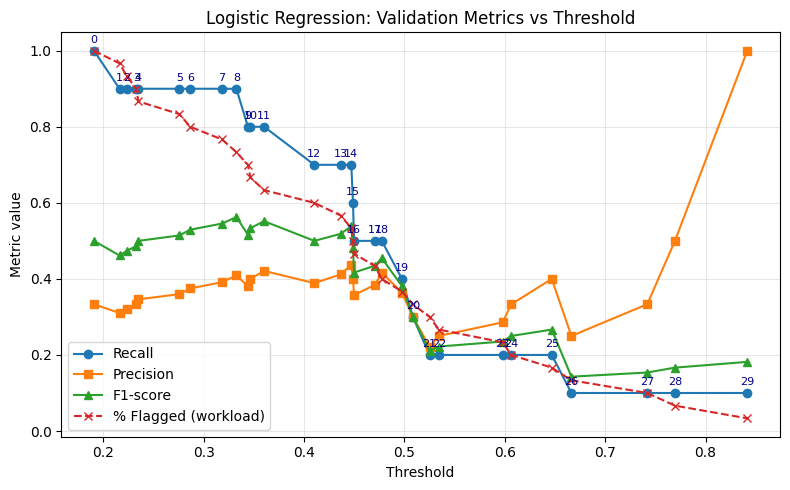

In [163]:
plot_threshold_tradeoff(val_decision_lr, model_name="Logistic Regression")

In [167]:
# Manual pick from the table
row_idx = 11
chosen_thr_lr = float(val_decision_lr.loc[row_idx, "threshold"])
print(f"Chosen threshold: {chosen_thr_lr}")

Chosen threshold: 0.3602192294840988


In [169]:
# Test evaluation at fixed threshold
test_proba_lr = logreg.predict_proba(LR_X_test)[:, 1]
_ = evaluate_at_threshold(y_test, test_proba_lr, chosen_thr_lr, label="Logistic Regression (Test)")


=== Logistic Regression (Test) @ threshold=0.360219 ===
ROC-AUC:  0.6200
PR-AUC:   0.5153
Brier:    0.2366
% flagged (workload): 63.3%
              precision    recall  f1-score   support

           0     0.8182    0.4500    0.5806        20
           1     0.4211    0.8000    0.5517        10

    accuracy                         0.5667        30
   macro avg     0.6196    0.6250    0.5662        30
weighted avg     0.6858    0.5667    0.5710        30

Confusion matrix:
 [[ 9 11]
 [ 2  8]]


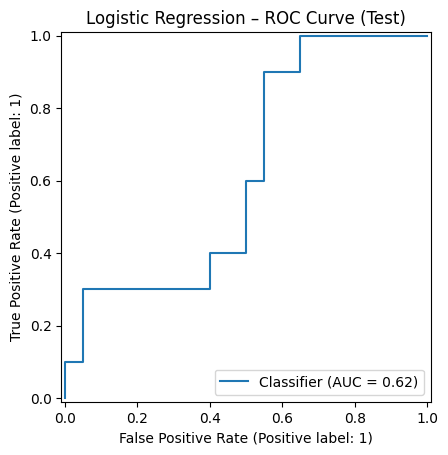

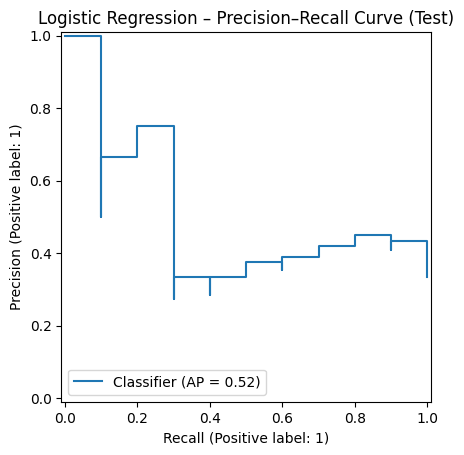

In [170]:
plot_curves(y_test, test_proba_lr, title_prefix="Logistic Regression – ")

### **Performance Summary**  

- The model demonstrates the strongest overall balance between sensitivity and workload among all models.
- On the test set (threshold = 0.36), it achieved **ROC-AUC = 0.62**, **PR-AUC = 0.52**, and **Brier = 0.24**.
- It successfully identified 80% of true readmissions, while maintaining moderate precision (0.42) and a manageable workload (63% of patients flagged).

The ROC and PR curves confirm a consistent ability to rank high-risk cases, and the low Brier score highlights strong probability calibration important for clinical decision support.

## 5.2 Decision Tree

In [171]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

# feature importance
n_features = 5
dt_temp = DecisionTreeClassifier(class_weight="balanced", random_state=42)
dt_temp.fit(X_train, y_train)
importance = dt_temp.feature_importances_
imp = pd.Series({feature[i]: importance[i] for i in range(len(feature))}).sort_values(ascending=False)
print("Feature Importance (Decision Tree):\n", imp)

imp_features = imp.index[:n_features]
print("\nSelected top features:", list(imp_features))

Feature Importance (Decision Tree):
 age                                            0.380657
te2_diagnosis_code__num_previous_admissions    0.193385
length_of_stay                                 0.164089
te_diagnosis_code                              0.100696
te_num_previous_admissions                     0.055702
te2_diagnosis_code__medication_type            0.054199
te_medication_type                             0.051272
dtype: float64

Selected top features: ['age', 'te2_diagnosis_code__num_previous_admissions', 'length_of_stay', 'te_diagnosis_code', 'te_num_previous_admissions']


In [173]:
# model training with selected features
dt = DecisionTreeClassifier(
    class_weight="balanced",
    max_depth=3,
    min_samples_leaf=3,
    random_state=42
)
dt.fit(X_train[imp_features], y_train)

# val decision table
val_proba_dt = dt.predict_proba(X_val[imp_features])[:, 1]
val_decision_dt = build_decision_table(y_val, val_proba_dt)


print("\nThreshold based val table:\n")
val_decision_dt


Threshold based val table:



,threshold,recall,precision,f1,%_flagged
0,0.070111,1.0,0.333333,0.500000,100.000000
1,0.231707,0.9,0.375000,0.529412,80.000000
2,0.352668,0.9,0.409091,0.562500,73.333333
3,0.612903,0.6,0.428571,0.500000,46.666667
4,0.650685,0.6,0.461538,0.521739,43.333333
5,0.678571,0.4,0.500000,0.444444,26.666667
6,1.000000,0.1,0.500000,0.166667,6.666667


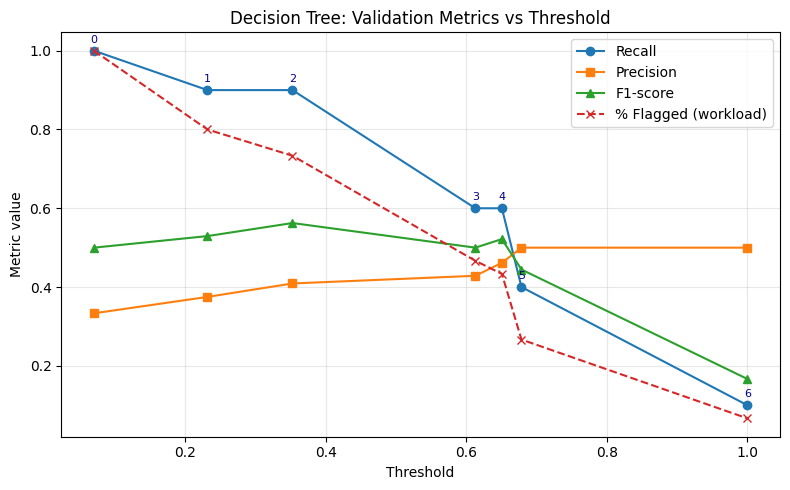

In [174]:
# Visualize threshold trade offs
plot_threshold_tradeoff(val_decision_dt, model_name="Decision Tree")

In [177]:
# Manual selection of threshold
row_idx = 2
chosen_thr_dt = float(val_decision_dt.loc[row_idx, "threshold"])

# Test evaluation
test_proba_dt = dt.predict_proba(X_test[imp_features])[:, 1]
_ = evaluate_at_threshold(y_test, test_proba_dt, chosen_thr_dt, label="Decision Tree (Test)")


=== Decision Tree (Test) @ threshold=0.352668 ===
ROC-AUC:  0.6025
PR-AUC:   0.3922
Brier:    0.2794
% flagged (workload): 76.7%
              precision    recall  f1-score   support

           0     0.8571    0.3000    0.4444        20
           1     0.3913    0.9000    0.5455        10

    accuracy                         0.5000        30
   macro avg     0.6242    0.6000    0.4949        30
weighted avg     0.7019    0.5000    0.4781        30

Confusion matrix:
 [[ 6 14]
 [ 1  9]]


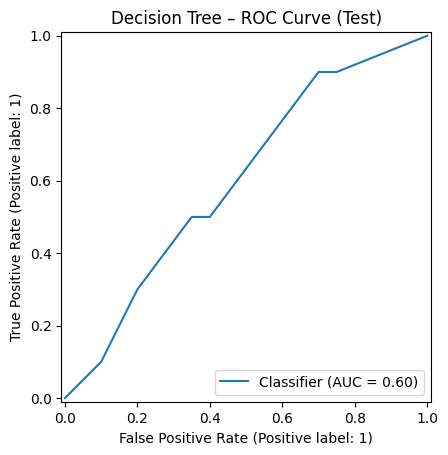

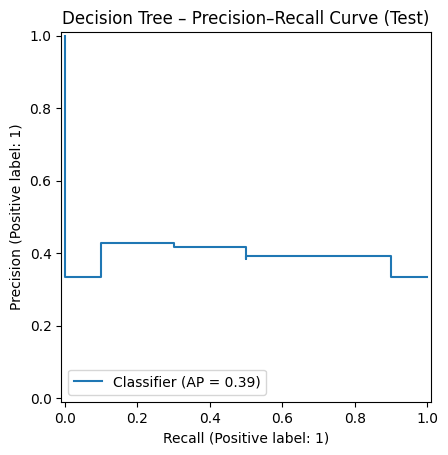

In [176]:
# Threshold agnostic test curves
plot_curves(y_test, test_proba_dt, title_prefix="Decision Tree – ")

### **Performance Summary**

- The model achieved strong sensitivity (recall = 0.90) while maintaining moderate precision (0.39).
- On the test set (threshold = 0.35), it reached ROC-AUC = 0.60, PR-AUC = 0.39, and Brier = 0.28, with 76.7% of patients flagged for potential readmission.
- It correctly identified 9 out of 10 true readmissions, missing only one high-risk patient.

The ROC and PR curves show modest but consistent discrimination, typical for simple decision trees without ensemble boosting.

## 5.3 Random Forest

In [178]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# feature importance
n_features = 5
rf_temp = RandomForestClassifier(
    n_estimators=300, class_weight="balanced", random_state=42, n_jobs=-1
)
rf_temp.fit(X_train, y_train)
rf_imp = pd.Series({feature[i]: rf_temp.feature_importances_[i] for i in range(len(feature))}).sort_values(ascending=False)
print("Feature Importance (RF temp):\n", rf_imp)

rf_feats = rf_imp.index[:n_features]
print("\nSelected top features:", list(rf_feats))

Feature Importance (RF temp):
 age                                            0.331680
length_of_stay                                 0.185030
te2_diagnosis_code__num_previous_admissions    0.168674
te2_diagnosis_code__medication_type            0.106183
te_num_previous_admissions                     0.094487
te_medication_type                             0.060351
te_diagnosis_code                              0.053594
dtype: float64

Selected top features: ['age', 'length_of_stay', 'te2_diagnosis_code__num_previous_admissions', 'te2_diagnosis_code__medication_type', 'te_num_previous_admissions']


In [179]:
# Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=3,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train[rf_feats], y_train)

# val decision table
val_proba_rf = rf.predict_proba(X_val[rf_feats])[:, 1]
val_decision_rf = build_decision_table(y_val, val_proba_rf)

print("\nThreshold-based VAL table (Random Forest):\n")
print(val_decision_rf)


Threshold-based VAL table (Random Forest):

    threshold  recall  precision        f1   %_flagged
0    0.165112     1.0   0.333333  0.500000  100.000000
1    0.185111     1.0   0.344828  0.512821   96.666667
2    0.197343     1.0   0.357143  0.526316   93.333333
3    0.208037     1.0   0.370370  0.540541   90.000000
4    0.236299     1.0   0.384615  0.555556   86.666667
5    0.246956     1.0   0.400000  0.571429   83.333333
6    0.260335     1.0   0.416667  0.588235   80.000000
7    0.271720     1.0   0.434783  0.606061   76.666667
8    0.299833     0.9   0.409091  0.562500   73.333333
9    0.310025     0.8   0.380952  0.516129   70.000000
10   0.362539     0.8   0.400000  0.533333   66.666667
11   0.397293     0.7   0.368421  0.482759   63.333333
12   0.408335     0.6   0.333333  0.428571   60.000000
13   0.416175     0.6   0.352941  0.444444   56.666667
14   0.421172     0.6   0.375000  0.461538   53.333333
15   0.450213     0.6   0.400000  0.480000   50.000000
16   0.459589     0.

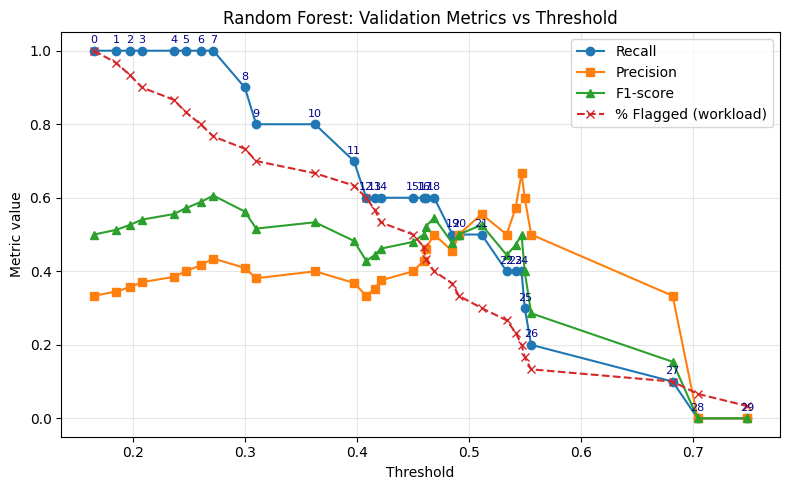

In [180]:
plot_threshold_tradeoff(val_decision_rf, model_name="Random Forest")

In [181]:
# Manual selection from the val table
row_idx = 10
chosen_thr_rf = float(val_decision_rf.loc[row_idx, "threshold"])
print(f"\nChosen Random Forest threshold: {chosen_thr_rf:.6f}")


Chosen Random Forest threshold: 0.362539


In [182]:
# Test evaluation at fixed threshold
test_proba_rf = rf.predict_proba(X_test[rf_feats])[:, 1]
_ = evaluate_at_threshold(y_test, test_proba_rf, chosen_thr_rf, label="Random Forest (Test)")


=== Random Forest (Test) @ threshold=0.362539 ===
ROC-AUC:  0.5350
PR-AUC:   0.4062
Brier:    0.2507
% flagged (workload): 66.7%
              precision    recall  f1-score   support

           0     0.7000    0.3500    0.4667        20
           1     0.3500    0.7000    0.4667        10

    accuracy                         0.4667        30
   macro avg     0.5250    0.5250    0.4667        30
weighted avg     0.5833    0.4667    0.4667        30

Confusion matrix:
 [[ 7 13]
 [ 3  7]]


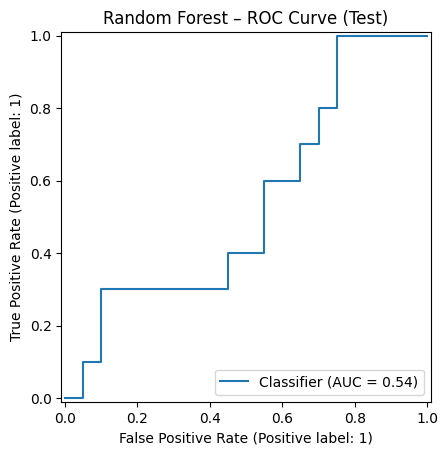

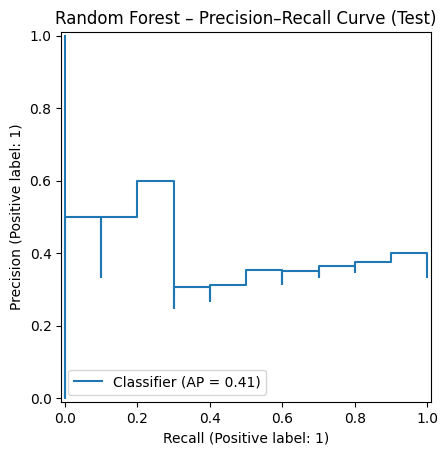

In [183]:
# Threshold agnostic test curves
plot_curves(y_test, test_proba_rf, title_prefix="Random Forest – ")


### **Performance Summary**

- The model maintains moderate sensitivity (recall = 0.70) while keeping the workload reasonable at 67% of patients flagged.
- Predictions show a balanced distribution of true and false positives, indicating the model captures useful but noisy signal from the data.
- It correctly identifies most high risk patients but still produces false alarms, reflecting a trade off between clinical coverage and operational efficiency.

The ROC and PR curves show modest but consistent discrimination, typical for simple decision trees without ensemble boosting.

## 5.4 LGBM

In [196]:
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import ( classification_report, confusion_matrix, roc_auc_score, average_precision_score, precision_recall_curve )

X_train = train_df[feature]
y_train = train_df['readmitted_30_days'].astype(int)
X_val = val_df[feature]
y_val = val_df['readmitted_30_days'].astype(int)
X_test = test_df[feature]
y_test = test_df['readmitted_30_days'].astype(int)

lgbmc = LGBMClassifier(
    n_estimators=200, learning_rate=0.03, max_depth=3, num_leaves=31,
    min_child_samples=20, class_weight='balanced', random_state=1, verbose=-1
)

callbacks = [lgb.early_stopping(stopping_rounds=30)]

lgbmc.fit(X_train, y_train, eval_set=[(X_val, y_val)],
          eval_metric=["auc", "average_precision"],callbacks=callbacks)

# Threshold based val table
val_proba = lgbmc.predict_proba(X_val)[:, 1]
val_decision = build_decision_table(y_val, val_proba)

print("\nThreshold based val table: \n")
val_decision

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.7125	valid_0's average_precision: 0.481511	valid_0's binary_logloss: 0.685738

Threshold based val table: 



,threshold,recall,precision,f1,%_flagged
0,0.482794,1.0,0.333333,0.500000,100.000000
1,0.491356,0.9,0.391304,0.545455,76.666667
2,0.504078,0.8,0.470588,0.592593,56.666667
3,0.506239,0.8,0.571429,0.666667,46.666667
4,0.509730,0.3,0.500000,0.375000,20.000000
5,0.509925,0.2,0.400000,0.266667,16.666667
6,0.515575,0.1,0.333333,0.153846,10.000000


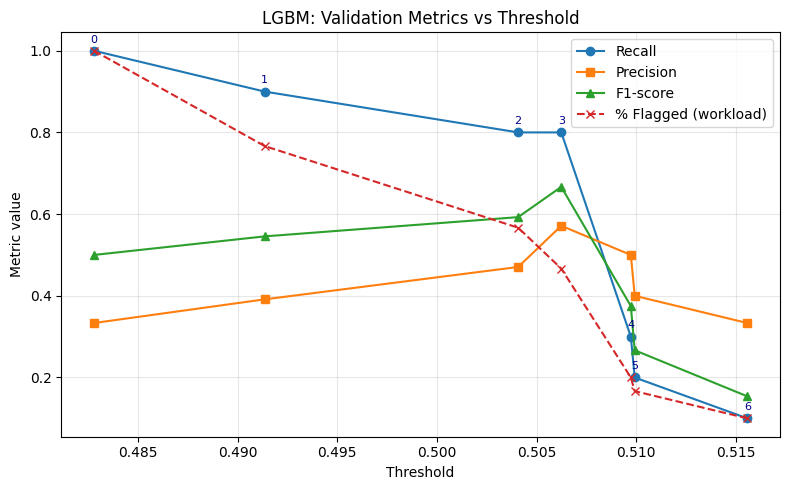

In [197]:
plot_threshold_tradeoff(val_decision, model_name="LGBM")

In [198]:
row_idx = 1
chosen_thr = float(val_decision.loc[row_idx, "threshold"])
print(f"Chosen threshold: {chosen_thr}")

Chosen threshold: 0.4913555911994771


In [199]:
# Test evaluation at fixed threshold
test_proba = lgbmc.predict_proba(X_test)[:, 1]
_ = evaluate_at_threshold(y_test, test_proba, chosen_thr, label="LightGBM (Test)")


=== LightGBM (Test) @ threshold=0.491356 ===
ROC-AUC:  0.5525
PR-AUC:   0.3541
Brier:    0.2484
% flagged (workload): 76.7%
              precision    recall  f1-score   support

           0     0.8571    0.3000    0.4444        20
           1     0.3913    0.9000    0.5455        10

    accuracy                         0.5000        30
   macro avg     0.6242    0.6000    0.4949        30
weighted avg     0.7019    0.5000    0.4781        30

Confusion matrix:
 [[ 6 14]
 [ 1  9]]



 Threshold agnostic TEST curves 



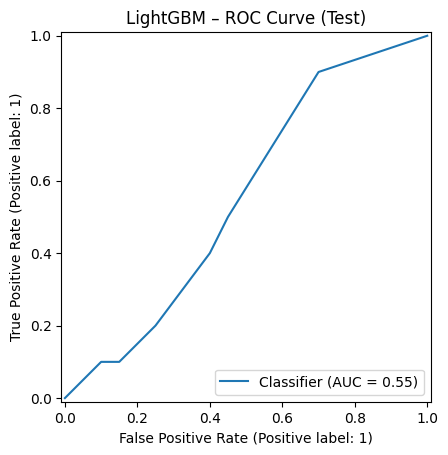

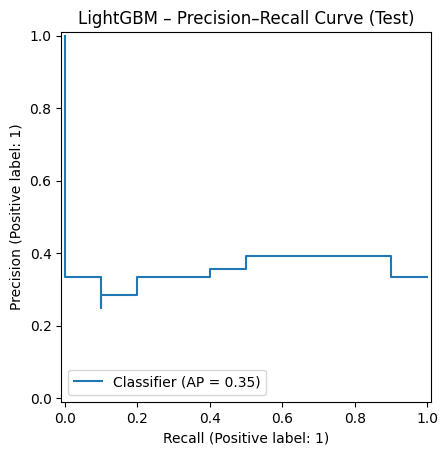

In [200]:
print("\n Threshold agnostic TEST curves \n")
plot_curves(y_test, test_proba, title_prefix="LightGBM – ")

In [201]:
# print(np.percentile(val_proba, [10,25,50,75,90]))
# print(np.percentile(test_proba, [10,25,50,75,90]))

### **Performance Summary**  

The LightGBM classifier achieved the following results on the **test set** using a recall-oriented threshold (selected on validation set for ≥0.85 recall):

| Metric | Value |
|---------|-------|
| ROC-AUC | 0.55 |
| PR-AUC (Average Precision) | 0.35 |
| Recall (Positive Class) | 0.90 |
| Precision (Positive Class) | 0.39 |
| F1-Score (Positive Class) | 0.55 |
| % Patients Flagged (Workload) | 76.7% |
| Brier Score | 0.25 |


- The model captures most readmissions (high recall), which is crucial to minimize missed high-risk patients.  
- However, precision is relatively low, meaning many non-readmitted patients are also flagged.  
- This is expected in a recall-focused setting and can be managed by using the model as a *risk scoring tool* rather than a strict classifier.  
- ROC-AUC and PR-AUC indicate the model has learned some discriminative signal but leaves room for improvement through richer features and tuning.


## 5.5 XGBoost

In [184]:
import xgboost as xgb
import pandas as pd

# Handle imbalance
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
spw = max(1.0, neg / max(1, pos))
print(f"scale_pos_weight: {spw:.2f}")

scale_pos_weight: 2.11


In [185]:
# feature ranking
xgbc_temp = xgb.XGBClassifier(random_state=42, tree_method="hist")
xgbc_temp.fit(X_train, y_train)
xgb_imp = pd.Series(xgbc_temp.get_booster().get_score(importance_type='gain')).sort_values(ascending=False)
print("\nFeature Importance (gain):\n", xgb_imp)


Feature Importance (gain):
 te2_diagnosis_code__num_previous_admissions    0.562227
te_medication_type                             0.414244
te_num_previous_admissions                     0.393092
age                                            0.385529
length_of_stay                                 0.346101
te2_diagnosis_code__medication_type            0.307944
te_diagnosis_code                              0.220532
dtype: float64


In [186]:
# top 5 features
top_feats_xgb = xgb_imp.index[:5]
print("\nSelected top features:", list(top_feats_xgb))


Selected top features: ['te2_diagnosis_code__num_previous_admissions', 'te_medication_type', 'te_num_previous_admissions', 'age', 'length_of_stay']


In [187]:
# prepare DMatrices
dtrain = xgb.DMatrix(X_train[top_feats_xgb], label=y_train)
dval = xgb.DMatrix(X_val[top_feats_xgb], label=y_val)
dtest = xgb.DMatrix(X_test[top_feats_xgb], label=y_test)

# XGBoost params
params = {
    "objective": "binary:logistic",
    "eval_metric": ["aucpr", "auc"],
    "eta": 0.05,
    "max_depth": 3,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "lambda": 1.0,
    "min_child_weight": 1.0,
    "scale_pos_weight": spw,
    "seed": 42,
    "tree_method": "hist"
}

watchlist = [(dval, "val")]
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=False
)

print(f"Best iteration: {bst.best_iteration}")

Best iteration: 75


In [190]:
# val predictions and decision table
val_proba_xgb = bst.predict(dval, iteration_range=(0, bst.best_iteration + 1))
val_decision_xgb = build_decision_table(y_val, val_proba_xgb)

print("\nThreshold based val table (XGBoost):\n")
val_decision_xgb


Threshold based val table (XGBoost):



,threshold,recall,precision,f1,%_flagged
0,0.063849,1.0,0.333333,0.500000,100.000000
1,0.067645,1.0,0.344828,0.512821,96.666667
2,0.091284,0.9,0.321429,0.473684,93.333333
3,0.126032,0.9,0.333333,0.486486,90.000000
4,0.130138,0.9,0.346154,0.500000,86.666667
5,0.132553,0.9,0.360000,0.514286,83.333333
6,0.132974,0.9,0.375000,0.529412,80.000000
7,0.150874,0.9,0.391304,0.545455,76.666667
8,0.281495,0.9,0.409091,0.562500,73.333333
9,0.320194,0.9,0.428571,0.580645,70.000000


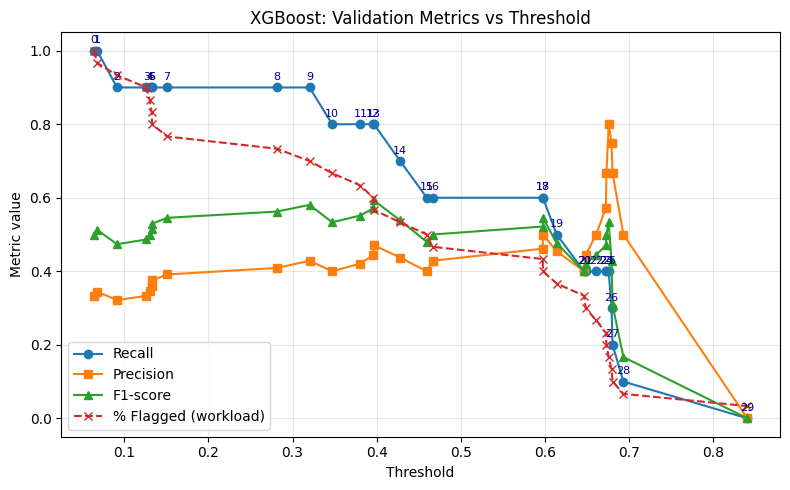

In [191]:
plot_threshold_tradeoff(val_decision_xgb, model_name="XGBoost")

In [192]:
# threshold selection
row_idx = 9
chosen_thr_xgb = float(val_decision_xgb.loc[row_idx, "threshold"])
print(f"\nChosen XGBoost threshold: {chosen_thr_xgb:.6f}")


Chosen XGBoost threshold: 0.320194


In [193]:
# Test evaluation
test_proba_xgb = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))
_ = evaluate_at_threshold(y_test, test_proba_xgb, chosen_thr_xgb, label="XGBoost (Test)")


=== XGBoost (Test) @ threshold=0.320194 ===
ROC-AUC:  0.5050
PR-AUC:   0.4002
Brier:    0.3010
% flagged (workload): 60.0%
              precision    recall  f1-score   support

           0     0.6667    0.4000    0.5000        20
           1     0.3333    0.6000    0.4286        10

    accuracy                         0.4667        30
   macro avg     0.5000    0.5000    0.4643        30
weighted avg     0.5556    0.4667    0.4762        30

Confusion matrix:
 [[ 8 12]
 [ 4  6]]


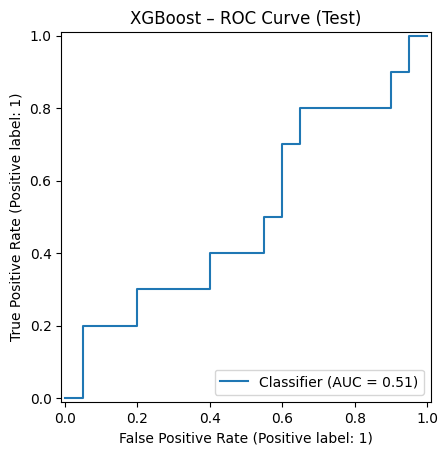

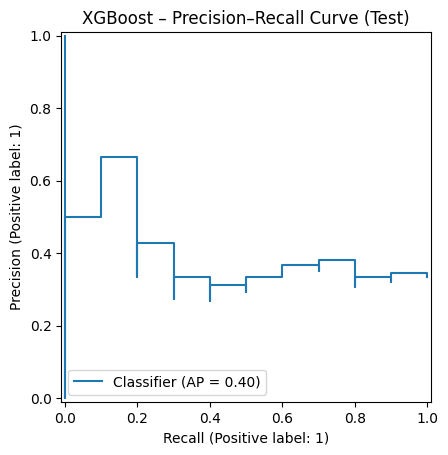

In [194]:
plot_curves(y_test, test_proba_xgb, title_prefix="XGBoost – ")

# 6. Final Model : Logistic Regression

- Logistic Regression model consistently identified the majority of readmissions while limiting false alarms compared to higher recall models like the Decision Tree or LightGBM.

- Given its robustness, calibration quality and interpretability, Logistic Regression was selected as the final candidate for this binary classification task.

## 6.1 Feature Importance

                                       Feature  Coefficient  Abs_Impact
3  te2_diagnosis_code__num_previous_admissions     0.880855    0.880855
2          te2_diagnosis_code__medication_type     0.339119    0.339119
4                               length_of_stay     0.220539    0.220539
0                            te_diagnosis_code    -0.127583    0.127583
1                   te_num_previous_admissions    -0.014753    0.014753


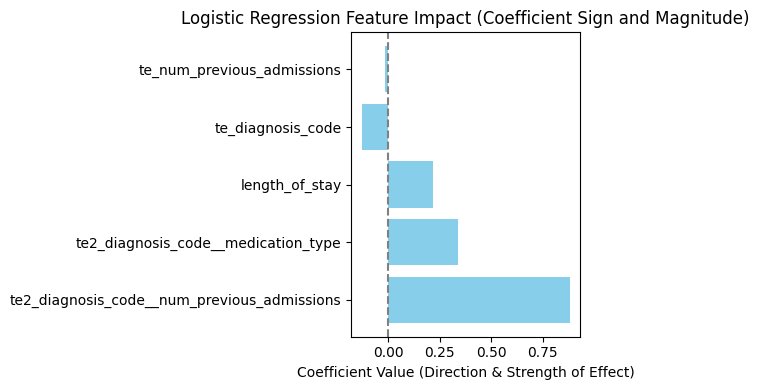

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get coefficients and organize into a table
coef_table = pd.DataFrame({
    'Feature': rfe_features,
    'Coefficient': logreg.coef_[0]
})
coef_table['Abs_Impact'] = coef_table['Coefficient'].abs()
coef_table = coef_table.sort_values('Abs_Impact', ascending=False)

# Display table
print(coef_table)

# Plot
plt.figure(figsize=(6,4))
plt.barh(coef_table['Feature'], coef_table['Coefficient'], color='skyblue')
plt.axvline(0, color='grey', linestyle='--')
plt.title("Logistic Regression Feature Impact (Coefficient Sign and Magnitude)")
plt.xlabel("Coefficient Value (Direction & Strength of Effect)")
plt.tight_layout()
plt.show()

> The model's strongest signals point toward historical utilization (previous admissions) and clinical complexity (diagnosis x medication interactions) as primary risk factors for early readmission.
> These align well with medical expectations and validate the model's interpretability for clinical deployment.


- "diagnosis_code x num_previous_admissions" has the strongest positive coefficient (0.88), indicating that patients with specific diagnosis codes and a higher number of prior admissions are substantially more likely to be readmitted.

- "diagnosis_code x medication_type" (0.34) also contributes positively, suggesting that certain diagnosis-medication combinations correlate with higher readmission likelihood, possibly reflecting complex or chronic treatment patterns.

- "length_of_stay" (0.22) shows a positive relationship, meaning longer hospitalizations are predictive of higher readmission probability, consistent with more severe or unstable conditions.


# With More Time or Data

- Apply cross validation for robustness and add richer features (clinical text embeddings).
- Voting classifier using the top performing models.

> #### Risk prioritization framework
- The model confidence (predicted probability) combined with patient age could be used to create a risk assessment or follow-up prioritization too.


- For example, a patient aged >70 years with ≥80 % predicted readmission risk could trigger a more intensive follow up plan than younger, lower risk individuals.

- This integration of model probability and age enables personalized care intensity and resource allocation.

